# Code Generator

The requirement: use a Frontier model to generate high performance C++ code from Python code


<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../resources.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#f71;">Reminder: fetch latest code</h2>
            <span style="color:#f71;">I'm continually improving these labs, adding more examples and exercises.
            At the start of each week, it's worth checking you have the latest code.<br/>
            First do a <a href="https://chatgpt.com/share/6734e705-3270-8012-a074-421661af6ba9">git pull and merge your changes as needed</a>. Any problems? Try asking ChatGPT to clarify how to merge - or contact me!<br/><br/>
            After you've pulled the code, from the llm_engineering directory, in an Anaconda prompt (PC) or Terminal (Mac), run:<br/>
            <code>conda env update --f environment.yml --prune</code><br/>
            Or if you used virtualenv rather than Anaconda, then run this from your activated environment in a Powershell (PC) or Terminal (Mac):<br/>
            <code>pip install -r requirements.txt</code>
            <br/>Then restart the kernel (Kernel menu >> Restart Kernel and Clear Outputs Of All Cells) to pick up the changes.
            </span>
        </td>
    </tr>
</table>

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../important.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h1 style="color:#900;">Important Note</h1>
            <span style="color:#900;">
            In this lab, I use GPT-4o and Claude-3.5-Sonnet, which are the slightly higher priced models. The costs are still low, but if you'd prefer to keep costs ultra low, please make the suggested switches to the models (3 cells down from here).
            </span>
        </td>
    </tr>
</table>

In [41]:
# imports

import os
import io
import sys
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai
import anthropic
from IPython.display import Markdown, display, update_display
import gradio as gr
import subprocess

In [42]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')

In [43]:
# initialize
# NOTE - option to use ultra-low cost models by uncommenting last 2 lines

openai = OpenAI()
claude = anthropic.Anthropic()
OPENAI_MODEL = "gpt-4o"
CLAUDE_MODEL = "claude-3-5-sonnet-20240620"

# Want to keep costs ultra-low? Uncomment these lines:
# OPENAI_MODEL = "gpt-4o-mini"
# CLAUDE_MODEL = "claude-3-haiku-20240307"

In [44]:
system_message = "You are an assistant that reimplements Python code in high performance C++ for 2019 Mac with Intel chip. "
system_message += "Respond only with C++ code; use comments sparingly and do not provide any explanation other than occasional comments. "
system_message += "The C++ response needs to produce an identical output in the fastest possible time."

In [45]:
def user_prompt_for(python):
    user_prompt = "Rewrite this Python code in C++ with the fastest possible implementation that produces identical output in the least time. "
    user_prompt += "Respond only with C++ code; do not explain your work other than a few comments. "
    user_prompt += "Pay attention to number types to ensure no int overflows. Remember to #include all necessary C++ packages such as iomanip.\n\n"
    user_prompt += python
    return user_prompt

In [46]:
def messages_for(python):
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt_for(python)}
    ]

In [47]:
# write to a file called optimized.cpp

def write_output(cpp):
    code = cpp.replace("```cpp","").replace("```","")
    with open("optimized.cpp", "w") as f:
        f.write(code)

In [48]:
def optimize_gpt(python):    
    stream = openai.chat.completions.create(model=OPENAI_MODEL, messages=messages_for(python), stream=True)
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        print(fragment, end='', flush=True)
    write_output(reply)

In [49]:
def optimize_claude(python):
    result = claude.messages.stream(
        model=CLAUDE_MODEL,
        max_tokens=2000,
        system=system_message,
        messages=[{"role": "user", "content": user_prompt_for(python)}],
    )
    reply = ""
    with result as stream:
        for text in stream.text_stream:
            reply += text
            print(text, end="", flush=True)
    write_output(reply)

## test code #1 pi

In [11]:
pi = """
import time

def calculate(iterations, param1, param2):
    result = 1.0
    for i in range(1, iterations+1):
        j = i * param1 - param2
        result -= (1/j)
        j = i * param1 + param2
        result += (1/j)
    return result

start_time = time.time()
result = calculate(100_000_000, 4, 1) * 4
end_time = time.time()

print(f"Result: {result:.12f}")
print(f"Execution Time: {(end_time - start_time):.6f} seconds")
"""

## python run time - pi

In [12]:
exec(pi)

Result: 3.141592658589
Execution Time: 12.619323 seconds


## gpt4.0 c++
### code below to input different python code name: pi, python_hard

In [13]:
optimize_gpt(pi)

```cpp
#include <iostream>
#include <iomanip>
#include <chrono>

double calculate(long long iterations, double param1, double param2) {
    double result = 1.0;
    for (long long i = 1; i <= iterations; ++i) {
        double j = i * param1 - param2;
        result -= (1.0 / j);
        j = i * param1 + param2;
        result += (1.0 / j);
    }
    return result;
}

int main() {
    auto start_time = std::chrono::high_resolution_clock::now();
    double result = calculate(100000000LL, 4.0, 1.0) * 4.0;
    auto end_time = std::chrono::high_resolution_clock::now();

    std::chrono::duration<double> execution_time = end_time - start_time;
    
    std::cout << std::fixed << std::setprecision(12);
    std::cout << "Result: " << result << std::endl;
    std::cout << "Execution Time: " << execution_time.count() << " seconds" << std::endl;

    return 0;
}
```

## gpt4.0 c++ run time 

In [14]:
exec(pi)

Result: 3.141592658589
Execution Time: 12.806759 seconds


# Compiling C++ and executing

* Python code (python) => C++ code (optimized.cpp) => compiled executable file (optimized)

This next cell contains the command to compile a C++ file on my M1 Mac.  
It compiles the file `optimized.cpp` into an executable called `optimized`  
Then it runs the program called `optimized`

In the next lab (day4), a student has contributed a full solution that compiles to efficient code on Mac, PC and Linux!

You can wait for this, or you can google (or ask ChatGPT!) for how to do this on your platform, then replace the lines below.
If you're not comfortable with this step, you can skip it for sure - I'll show you exactly how it performs on my Mac.


OR alternatively: student Sandeep K.G. points out that you can run Python and C++ code online to test it out that way. Thank you Sandeep!  
> Not an exact comparison but you can still get the idea of performance difference.
> For example here: https://www.programiz.com/cpp-programming/online-compiler/

In [15]:
import os
print(os.getcwd())
print(os.listdir())

/Users/hongzhu/Documents/llm_engineering/week4
['optimized.cpp', 'day4-my.ipynb', 'simple.cpp', 'day3-my.ipynb', 'optimized', 'day4.ipynb', 'community-contributions', '.ipynb_checkpoints', 'day3.ipynb']


In [16]:
%%bash
which clang++
clang++ --version


/usr/bin/clang++
Apple clang version 17.0.0 (clang-1700.0.13.3)
Target: x86_64-apple-darwin24.5.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin


## gpt 4.0 c++ run time vs python: 0.21s  vs 13s
* Compiles a C++ source file (optimized.cpp) using the Clang compiler (clang++).
* Applies the highest level of compiler optimization (-O3).
* Uses the C++17 standard (-std=c++17).
* Optimizes the code for the native architecture (-march=native).
* Creates an executable file named optimized.
* Executes the generated optimized program.


In [17]:
%%bash
clang++ -O3 -std=c++17 -march=native -o optimized optimized.cpp
./optimized


Result: 3.141592658589
Execution Time: 0.208253313000 seconds


In [17]:
# Compile C++ and run the executable - Mac M1

# !clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
# !./optimized

## claude c++ code
### code below to input different python code name: pi, python_hard

In [18]:
optimize_claude(pi)

```cpp
#include <iostream>
#include <iomanip>
#include <chrono>

double calculate(long long iterations, double param1, double param2) {
    double result = 1.0;
    for (long long i = 1; i <= iterations; i++) {
        double j = i * param1 - param2;
        result -= (1.0 / j);
        j = i * param1 + param2;
        result += (1.0 / j);
    }
    return result;
}

int main() {
    long long iterations = 100'000'000;
    double param1 = 4.0, param2 = 1.0;

    auto start_time = std::chrono::high_resolution_clock::now();
    double result = calculate(iterations, param1, param2) * 4.0;
    auto end_time = std::chrono::high_resolution_clock::now();

    std::cout << std::fixed << std::setprecision(12) << "Result: " << result << std::endl;
    std::cout << std::fixed << std::setprecision(6) << "Execution Time: " << std::chrono::duration<double>(end_time - start_time).count() << " seconds" << std::endl;

    return 0;
}
```

# claude c++ run vs python : 0.21s vs 13s

In [19]:

%%bash
clang++ -O3 -std=c++17 -march=native -o optimized optimized.cpp
./optimized

Result: 3.141592658589
Execution Time: 0.192111 seconds


In [ ]:
# Repeat for Claude - again, use the right approach for your platform
# !clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
# !./optimized

## python test code #2 -  LCG

In [50]:
python_hard = """# Be careful to support large number sizes

def lcg(seed, a=1664525, c=1013904223, m=2**32):
    value = seed
    while True:
        value = (a * value + c) % m
        yield value
        
def max_subarray_sum(n, seed, min_val, max_val):
    lcg_gen = lcg(seed)
    random_numbers = [next(lcg_gen) % (max_val - min_val + 1) + min_val for _ in range(n)]
    max_sum = float('-inf')
    for i in range(n):
        current_sum = 0
        for j in range(i, n):
            current_sum += random_numbers[j]
            if current_sum > max_sum:
                max_sum = current_sum
    return max_sum

def total_max_subarray_sum(n, initial_seed, min_val, max_val):
    total_sum = 0
    lcg_gen = lcg(initial_seed)
    for _ in range(20):
        seed = next(lcg_gen)
        total_sum += max_subarray_sum(n, seed, min_val, max_val)
    return total_sum

# Parameters
n = 10000         # Number of random numbers
initial_seed = 42 # Initial seed for the LCG
min_val = -10     # Minimum value of random numbers
max_val = 10      # Maximum value of random numbers

# Timing the function
import time
start_time = time.time()
result = total_max_subarray_sum(n, initial_seed, min_val, max_val)
end_time = time.time()

print("Total Maximum Subarray Sum (20 runs):", result)
print("Execution Time: {:.6f} seconds".format(end_time - start_time))
"""

## python run tim1s - 41s

In [51]:
exec(python_hard)

## gpt 4.0 c++ code
### code below to input different python code name: pi, python_hard

In [52]:
optimize_gpt(python_hard)

## GPT4.0 - given user prompt has specific information, GPT4.0 produce incorrect answer

In [26]:
%%bash
clang++ -O3 -std=c++17 -march=native -o optimized optimized.cpp
./optimized

optimized.cpp:7:90: warning: implicit conversion from 'long' to 'uint32_t' (aka 'unsigned int') changes value from 4294967296 to 0 [-Wconstant-conversion]
    7 | uint32_t lcg(uint32_t &seed, uint32_t a = 1664525, uint32_t c = 1013904223, uint32_t m = 4294967296) {
      |                                                                                        ~ ^~~~~~~~~~
1 warning generated.


Total Maximum Subarray Sum (20 runs): 0
Execution Time: 0.518773 seconds


In [ ]:
# Replace this with the right C++ compile + execute command for your platform

# !clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
# !./optimized

## claude c++ 
### code below to input different python code name: pi, python_hard

In [27]:
optimize_claude(python_hard)

#include <iostream>
#include <vector>
#include <chrono>
#include <limits>
#include <iomanip>

using namespace std;
using namespace chrono;

class LCG {
private:
    uint64_t value;
    const uint64_t a = 1664525;
    const uint64_t c = 1013904223;
    const uint64_t m = 1ULL << 32;

public:
    LCG(uint64_t seed) : value(seed) {}

    uint64_t next() {
        value = (a * value + c) % m;
        return value;
    }
};

int64_t max_subarray_sum(int n, uint64_t seed, int min_val, int max_val) {
    LCG lcg(seed);
    vector<int64_t> random_numbers(n);
    for (int i = 0; i < n; ++i) {
        random_numbers[i] = lcg.next() % (max_val - min_val + 1) + min_val;
    }

    int64_t max_sum = numeric_limits<int64_t>::min();
    int64_t current_sum = 0;
    for (int i = 0; i < n; ++i) {
        current_sum = max(current_sum + random_numbers[i], random_numbers[i]);
        max_sum = max(max_sum, current_sum);
    }
    return max_sum;
}

int64_t total_max_subarray_sum(int n, uint64_t initial_s

## Claude is very very fast! 0.0007s vs 41s
* claude immplemented the code in c++ with one loop, efficient.

In [28]:
%%bash
clang++ -O3 -std=c++17 -march=native -o optimized optimized.cpp
./optimized

Total Maximum Subarray Sum (20 runs): 10980
Execution Time: 0.000790 seconds


In [ ]:
# Replace this with the right C++ compile + execute command for your platform

# !clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
# !./optimized

# Gradio UI - Python library
* quickly building and sharing interactive web application for ML models, APIs, and other tasks

In [20]:
# convert python to c++
def stream_gpt(python):    
    stream = openai.chat.completions.create(model=OPENAI_MODEL, messages=messages_for(python), stream=True)
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        yield reply.replace('```cpp\n','').replace('```','')

In [21]:
def stream_claude(python):
    result = claude.messages.stream(
        model=CLAUDE_MODEL,
        max_tokens=2000,
        system=system_message,
        messages=[{"role": "user", "content": user_prompt_for(python)}],
    )
    reply = ""
    with result as stream:
        for text in stream.text_stream:
            reply += text
            yield reply.replace('```cpp\n','').replace('```','')

In [22]:
def optimize(python, model):
    if model=="GPT":
        result = stream_gpt(python)
    elif model=="Claude":
        result = stream_claude(python)
    else:
        raise ValueError("Unknown model")
    for stream_so_far in result:
        yield stream_so_far        

# Construct web applictaion with Gradio interface
* Take Python code as input
* lets the user select a model for C++ conversion,
* displays the converted code.
* The optimize function performs the code conversion, though the specific conversion logic is not included in this snippet.
* The Gradio UI provides a method to interact with the code conversion process. 

### gr.Blocks(): This creates a Gradio block-based interface, which is more flexible and allows for more control over the UI layout than the simpler gr.Interface().
* Event Handling: The convert.click() sets up an event handler, connecting the button click to a specific function (optimize).
* Launching the UI: ui.launch(inbrowser=True) starts the web application and opens it in your default browser. 


### Code Breakdown:
* with gr.Blocks() as ui:
This initiates a Gradio block-based interface, assigning it to ui.
The user interface is built within this block.
* with gr.Row(): (First Row)
Creates a horizontal row to arrange UI elements side-by-side.
- python = gr.Textbox(label="Python code:", lines=10, value=pi)
- Creates a textbox for Python code input.
- label="Python code:": Sets the label above the textbox.
- lines=10: Sets the textbox to display 10 lines by default.
- value=pi: Sets the textbox's initial value to the variable pi. (Without knowing how pi is defined, the initial Python code displayed is unknown).
- 
- cpp = gr.Textbox(label="C++ code:", lines=10)
- Creates a textbox to display the converted C++ code.
- label="C++ code:": Sets the label above the textbox.
- lines=10: Sets the textbox to display 10 lines by default.

* with gr.Row(): (Second Row)
Creates another horizontal row.

- model = gr.Dropdown(["GPT", "Claude"], label="Select model", value="GPT")
- Creates a dropdown menu to select a code conversion model.
- ["GPT", "Claude"]: Specifies the dropdown options.
- label="Select model": Sets the label for the dropdown.
- value="GPT": Sets "GPT" as the default selection.
- convert = gr.Button("Convert code")
- Creates a button labeled "Convert code".
-

* convert.click(optimize, inputs=[python, model], outputs=[cpp])
- Connects the convert button to an event handler.
- convert.click(): Sets the button's click event to trigger a callback function.
- optimize: This is the function called when the button is clicked. It is presumed that optimize performs Python to C++ code conversion.
- inputs=[python, model]: Specifies that the optimize function uses two inputs: the content of the python textbox and the selected value from the model dropdown.
- outputs=[cpp]: Specifies that the optimize function returns one output, which updates the cpp textbox.

* ui.launch(inbrowser=True)
- Launches the Gradio web application.
- inbrowser=True: Opens the application in the default web browser automatically. 

## UI example:
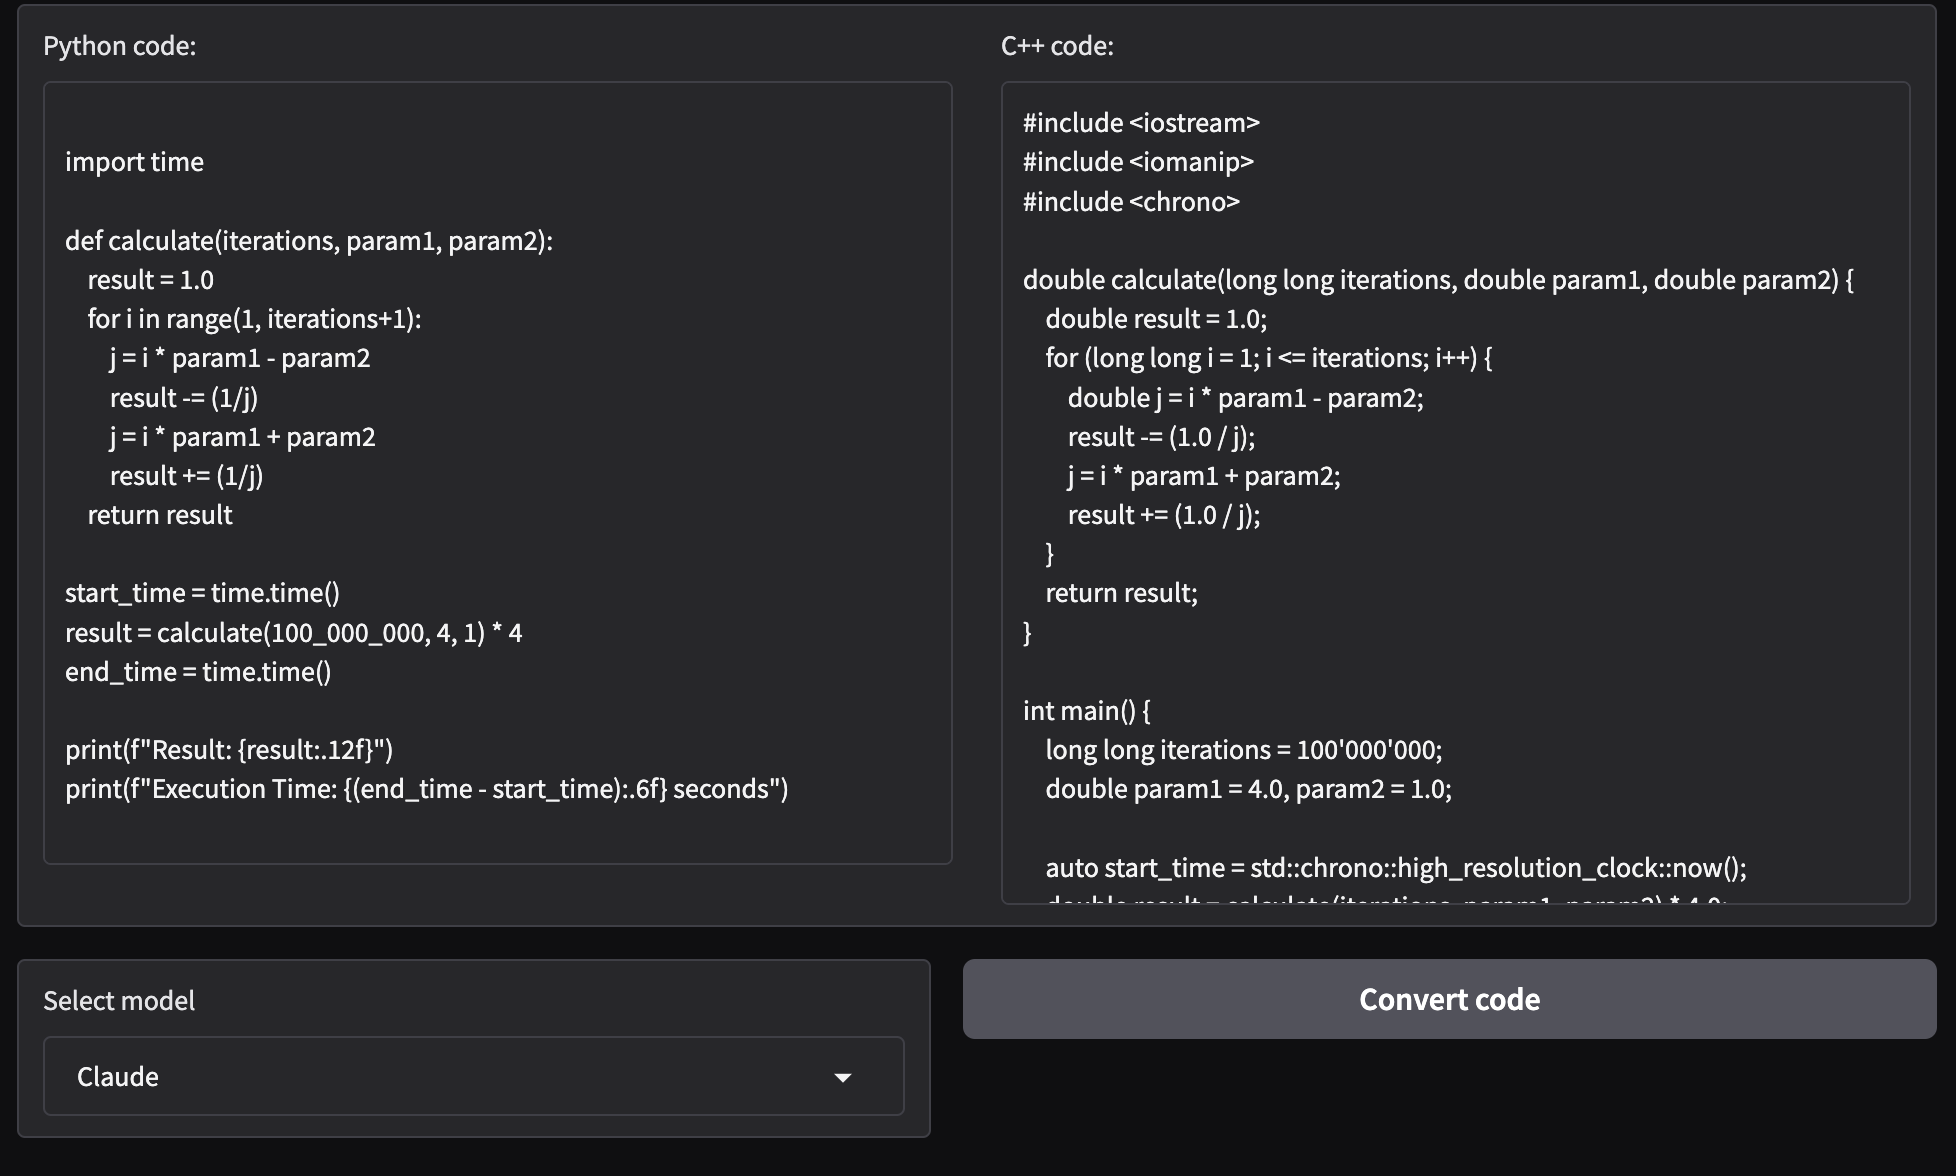

In [35]:
with gr.Blocks() as ui:
    with gr.Row():
        #python = gr.Textbox(label="Python code:", lines=10, value=pi)
        python = gr.Textbox(label="Python code:", lines=10, value=python_hard)
    
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        model = gr.Dropdown(["GPT", "Claude"], label="Select model", value="GPT")
        convert = gr.Button("Convert code")
    # (fn, fn_input, fn_output)
    convert.click(optimize, inputs=[python, model], outputs=[cpp])

ui.launch(inbrowser=True)

# DO NOT share this code with others, as others can exec python code on your box, which is BAD!

In [36]:
def execute_python(code):
    try:
        output = io.StringIO()
        sys.stdout = output
        exec(code)
    finally:
        sys.stdout = sys.__stdout__
    return output.getvalue()

In [37]:
import subprocess

def execute_cpp(code):
    # Step 1: Write the C++ code to a file
    with open("optimized.cpp", "w") as f:
        f.write(code)
    
    try:
        # Step 2: Compile the code
        compile_cmd = ["clang++", "-O3", "-std=c++17", "-march=native", "-o", "optimized", "optimized.cpp"]
        compile_result = subprocess.run(compile_cmd, check=True, capture_output=True, text=True)
        
        # Step 3: Run the compiled executable
        run_cmd = ["./optimized"]
        run_result = subprocess.run(run_cmd, check=True, capture_output=True, text=True)
        
        # Step 4: Return the output
        return run_result.stdout
    
    except subprocess.CalledProcessError as e:
        # Return any errors from compilation or execution
        return f"An error occurred:\n{e.stderr or e.stdout or str(e)}"


In [39]:
# %%bash
# clang++ -O3 -std=c++17 -march=native -o optimized optimized.cpp
# ./optimized


In [ ]:
# You'll need to change the code in the try block to compile the C++ code for your platform
# I pasted this into Claude's chat UI with a request for it to give me a version for an Intel PC,
# and it responded with something that looks perfect - you can try a similar approach for your platform.

# M1 Mac version to compile and execute optimized C++ code:

"""
def execute_cpp(code):
        write_output(code)
        try:
            compile_cmd = ["clang++", "-Ofast", "-std=c++17", "-march=armv8.5-a", "-mtune=apple-m1", "-mcpu=apple-m1", "-o", "optimized", "optimized.cpp"]
            compile_result = subprocess.run(compile_cmd, check=True, text=True, capture_output=True)
            run_cmd = ["./optimized"]
            run_result = subprocess.run(run_cmd, check=True, text=True, capture_output=True)
            return run_result.stdout
        except subprocess.CalledProcessError as e:
            return f"An error occurred:\n{e.stderr}"

"""            

In [38]:
css = """
.python {background-color: #306998;}
.cpp {background-color: #050;}
"""

## UI Example:
* OPENAI_MODEL = "gpt-4o-mini"

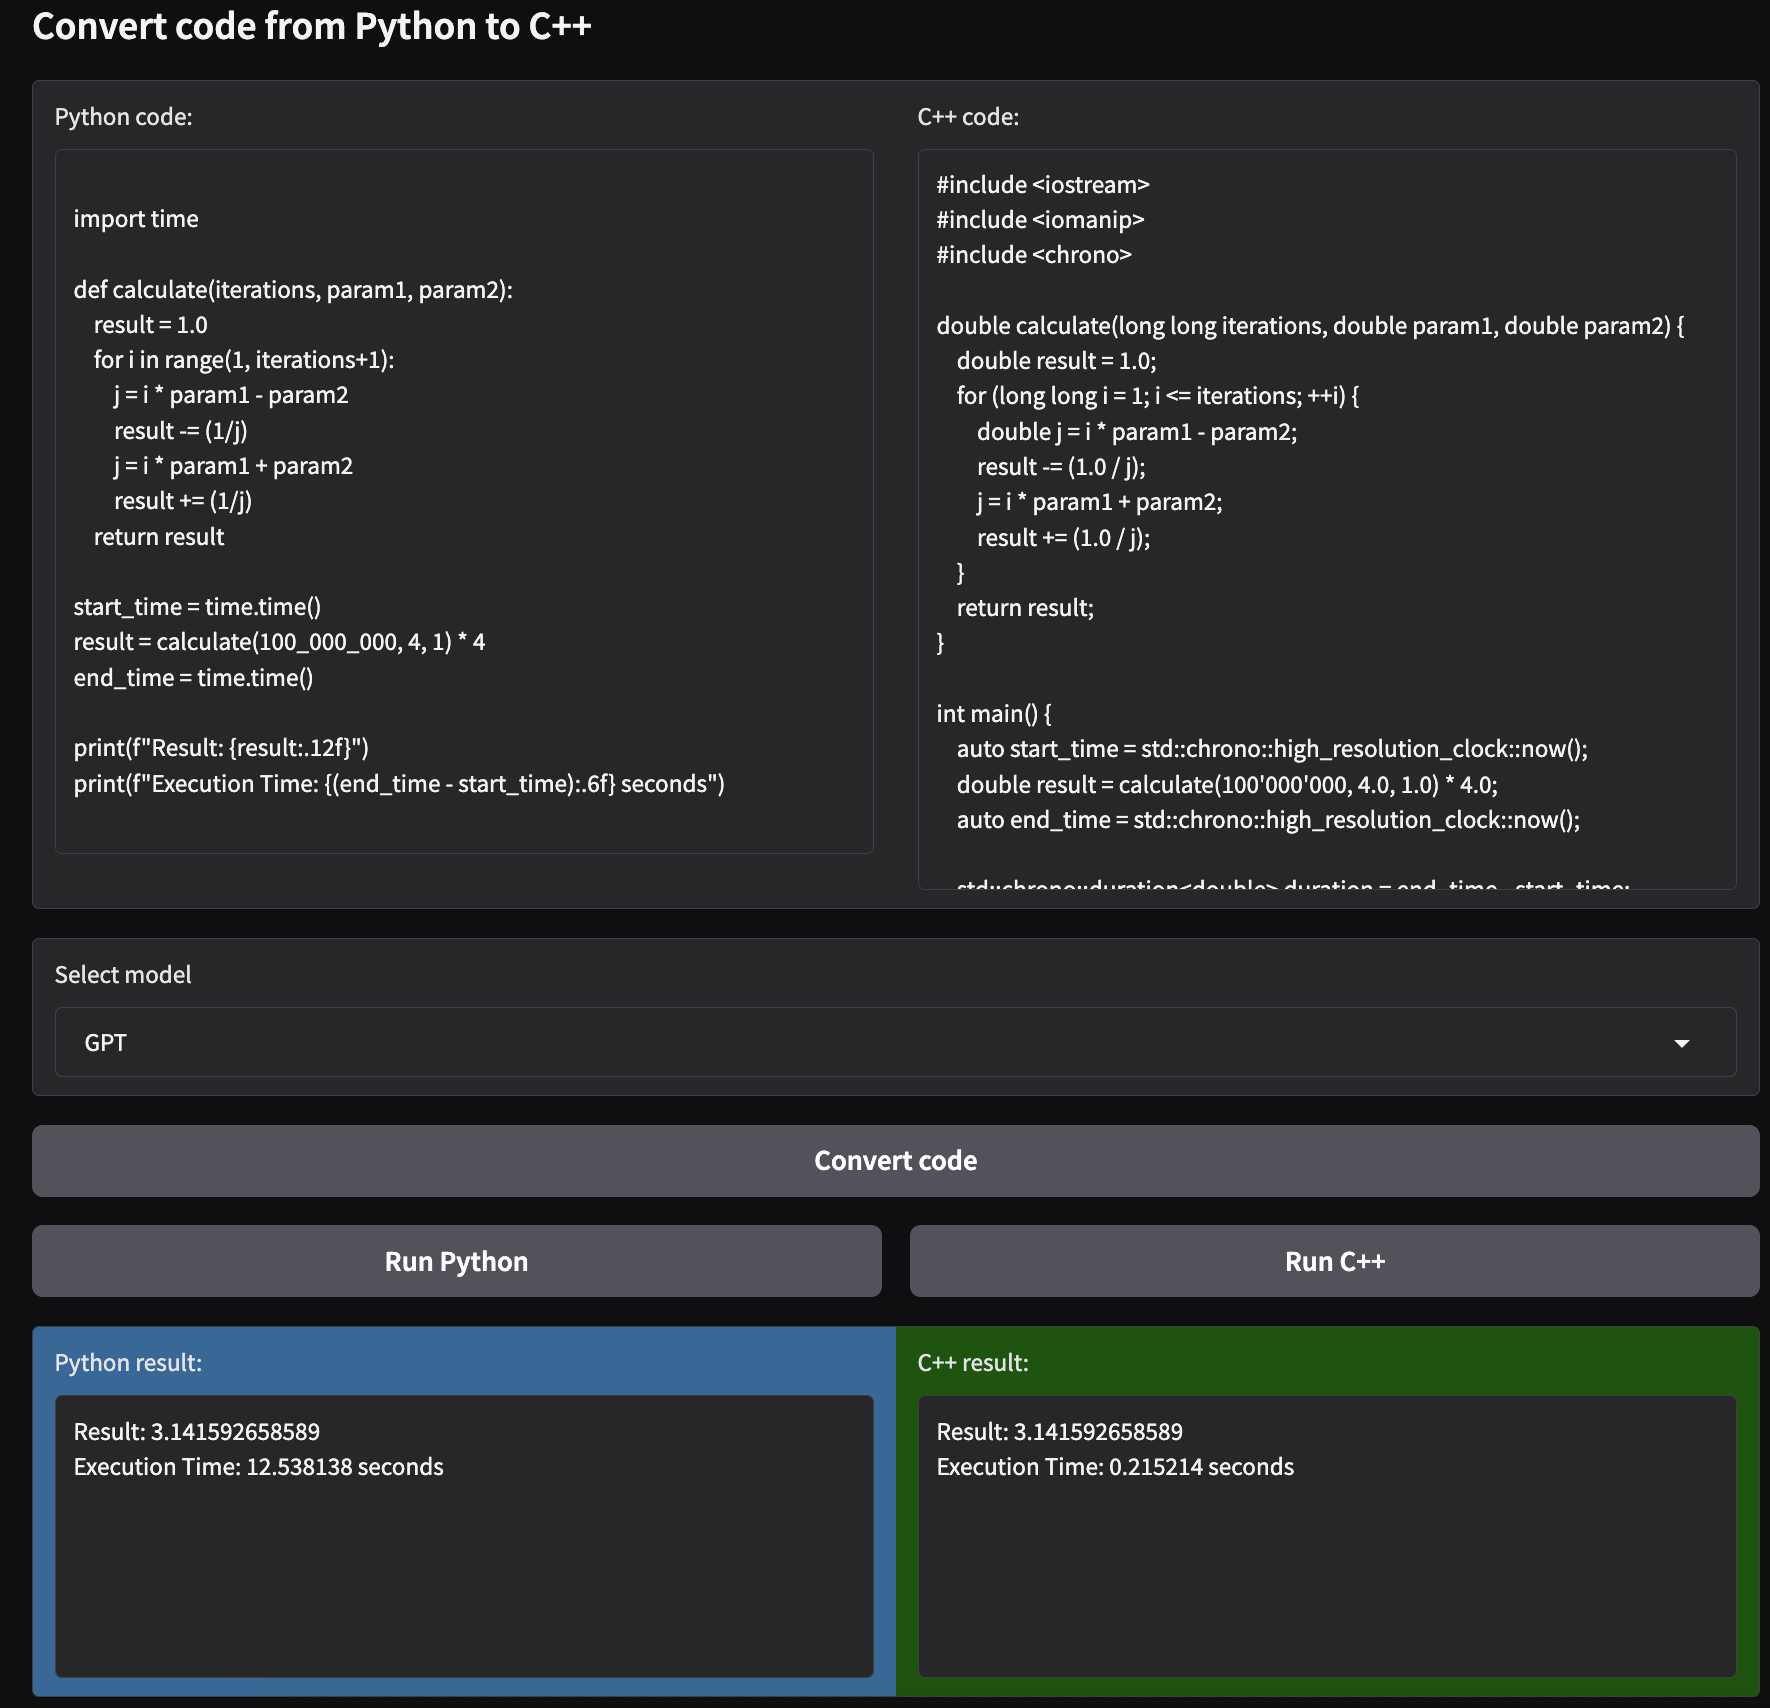

* CLAUDE_MODEL = "claude-3-haiku-20240307"

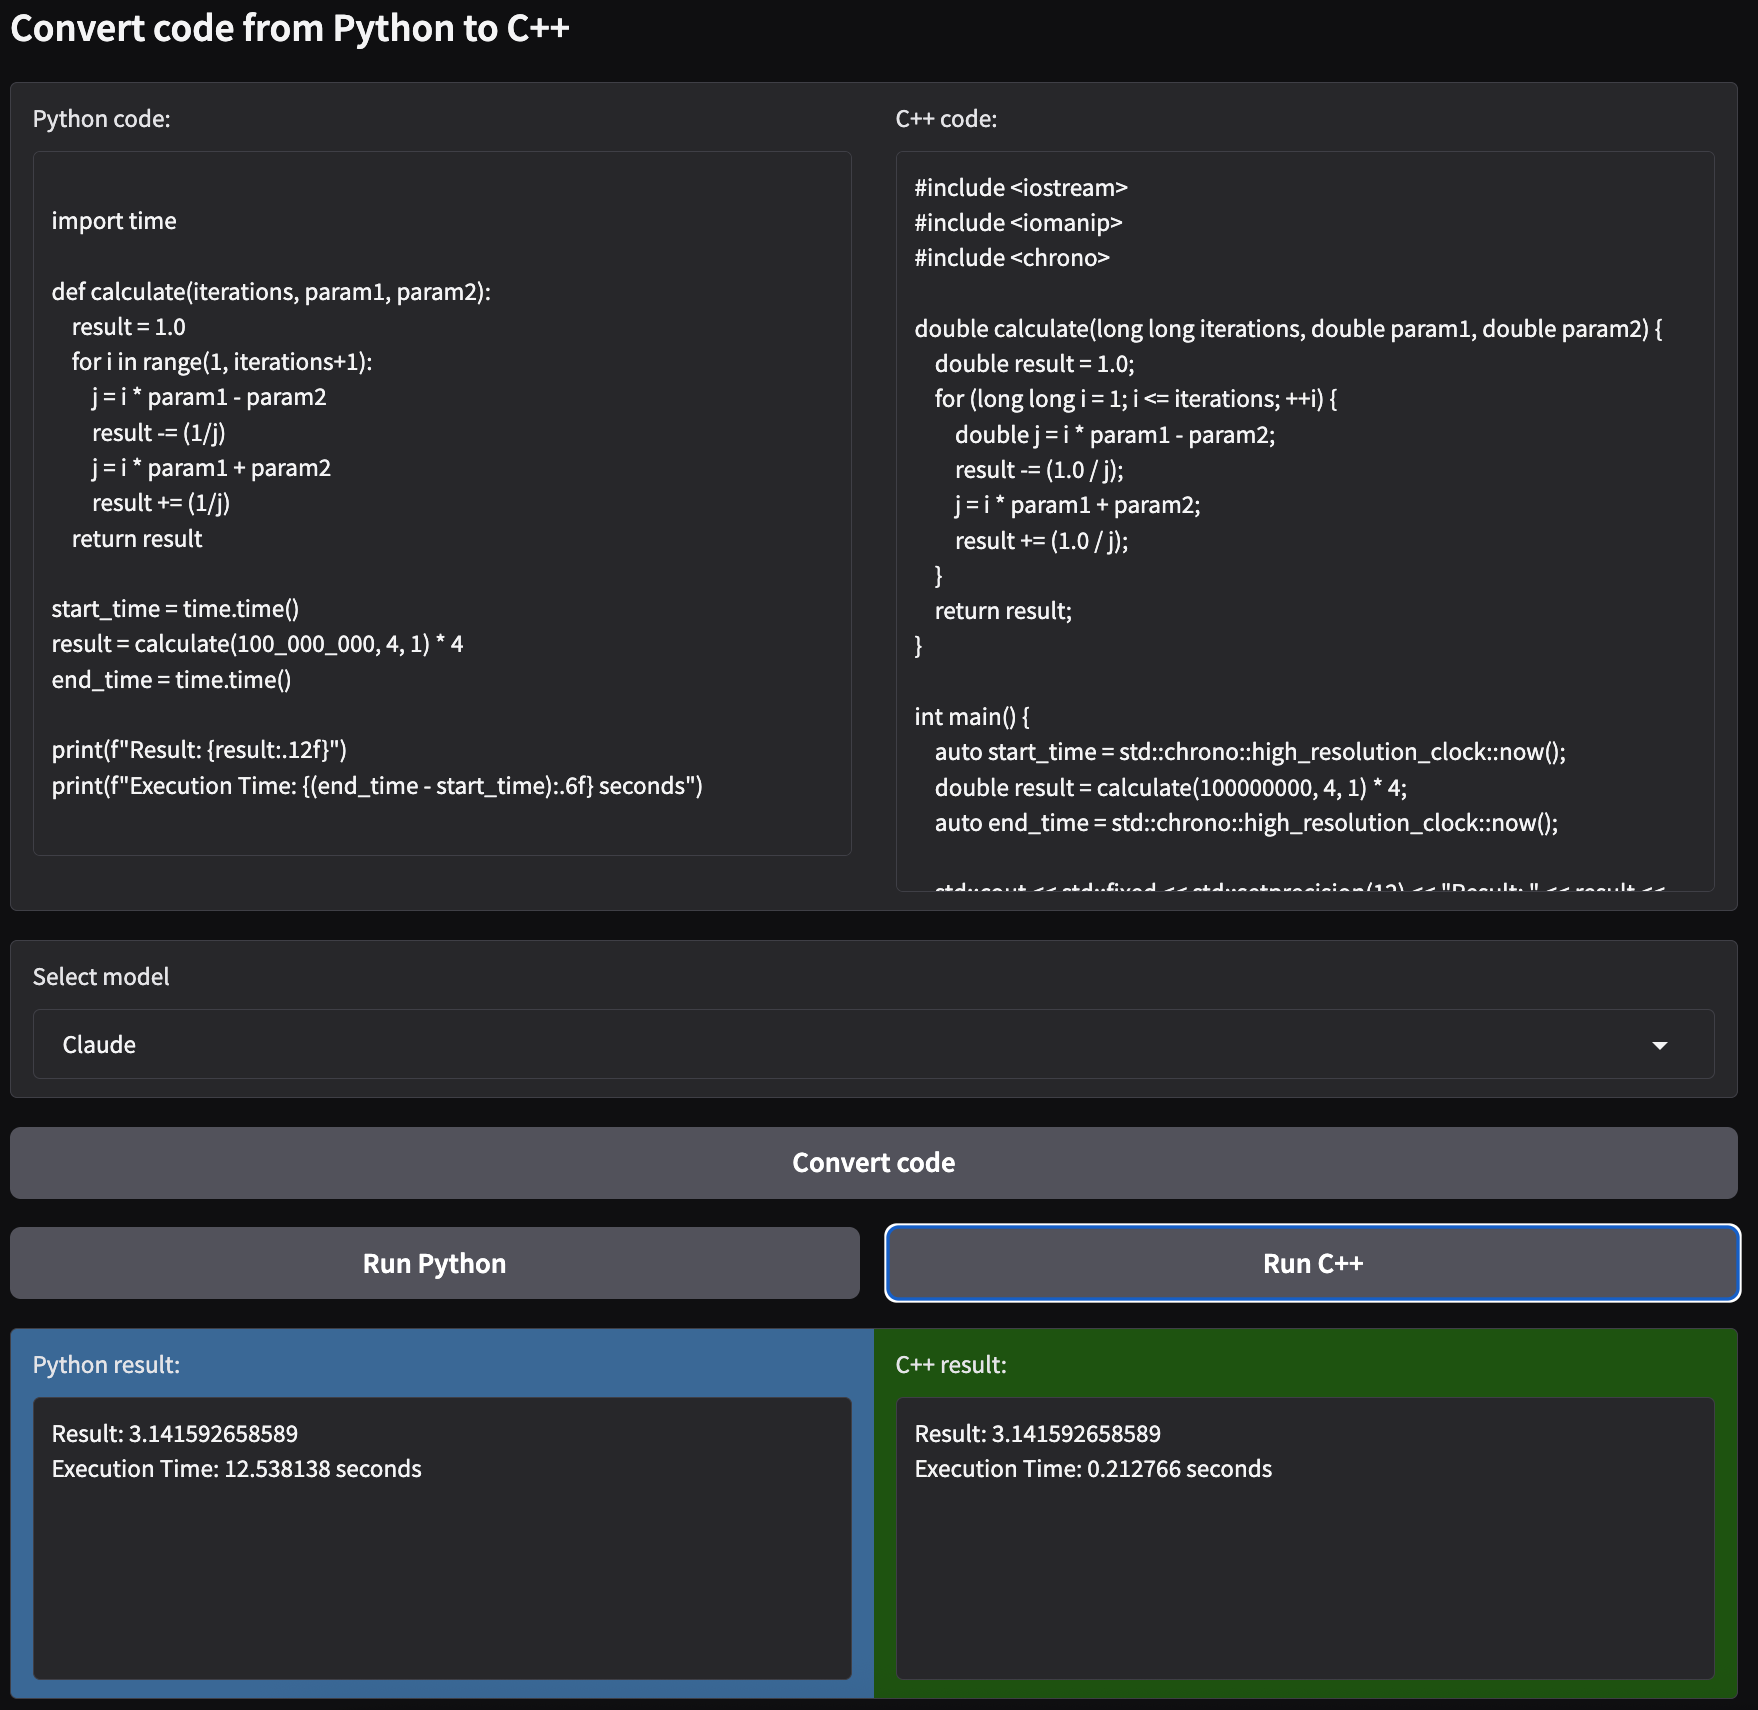

In [39]:
with gr.Blocks(css=css) as ui:
    gr.Markdown("## Convert code from Python to C++")
    with gr.Row():
        # python = gr.Textbox(label="Python code:", value=pi, lines=10)
        python = gr.Textbox(label="Python code:", value=python_hard, lines=10)
        
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        model = gr.Dropdown(["GPT", "Claude"], label="Select model", value="GPT")
    with gr.Row():
        convert = gr.Button("Convert code")
    with gr.Row():
        python_run = gr.Button("Run Python")
        cpp_run = gr.Button("Run C++")
    with gr.Row():
        python_out = gr.TextArea(label="Python result:", elem_classes=["python"])
        cpp_out = gr.TextArea(label="C++ result:", elem_classes=["cpp"])

    convert.click(optimize, inputs=[python, model], outputs=[cpp])
    python_run.click(execute_python, inputs=[python], outputs=[python_out])
    cpp_run.click(execute_cpp, inputs=[cpp], outputs=[cpp_out])

ui.launch(inbrowser=True)

Traceback (most recent call last):
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/blocks.py", line 2181, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/blocks.py", line 1692, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/anyio/to_thread.py", line 56, in run_sync
    return